<a href="https://colab.research.google.com/github/JhulianaM/seminario_EDSR/blob/master/Copy_of_Edsr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Deep Residual Networks for single-image super-resolution

**Author:** Gitesh Chawda<br>
**Date created:** 2022/04/07<br>
**Last modified:** 2022/04/07<br>
**Description:** Training an EDSR model on the DIV2K Dataset.

## Introduction

In this example, we implement
[Enhanced Deep Residual Networks for Single Image Super-Resolution (EDSR)](https://arxiv.org/abs/1707.02921)
by Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah, and Kyoung Mu Lee.

The EDSR architecture is based on the SRResNet architecture and consists of multiple
residual blocks. It uses constant scaling layers instead of batch normalization layers to
produce consistent results (input and output have similar distributions, thus
normalizing intermediate features may not be desirable). Instead of using a L2 loss (mean squared error),
the authors employed an L1 loss (mean absolute error), which performs better empirically.

Our implementation only includes 16 residual blocks with 64 channels.

Alternatively, as shown in the Keras example
[Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/#image-superresolution-using-an-efficient-subpixel-cnn),
you can do super-resolution using an ESPCN Model. According to the survey paper, EDSR is one of the top-five
best-performing super-resolution methods based on PSNR scores. However, it has more
parameters and requires more computational power than other approaches.
It has a PSNR value (≈34db) that is slightly higher than ESPCN (≈32db).
As per the survey paper, EDSR performs better than ESPCN.

Paper:
[A comprehensive review of deep learning based single image super-resolution](https://arxiv.org/abs/2102.09351)

Comparison Graph:
<img src="https://dfzljdn9uc3pi.cloudfront.net/2021/cs-621/1/fig-11-2x.jpg" width="500" />

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

## Download the training dataset

We use the DIV2K Dataset, a prominent single-image super-resolution dataset with 1,000
images of scenes with various sorts of degradations,
divided into 800 images for training, 100 images for validation, and 100
images for testing. We use 4x bicubic downsampled images as our "low quality" reference.

In [2]:
# Baixamos o conjunto de dados. DIV2K from TF Datasets
# Using configuration bicubic 4x degradation type
# As imagens são degradadas usando o método bicúbico em uma escala de 4x.
# Cria o objeto div2k_data que representa o conjunto de dados DIV2K com a configuração 4x bicúbica.
div2k_data = tfds.image.Div2k(config="bicubic_x4")
# Os dados são baixados e preparados
div2k_data.download_and_prepare()

#Taking train data from div2k_data object

# split=train indica que estamos solicitando a divisão de treinamento do conjunto de dados DIV2K.
# as_supervised=True os dados serão carregados em formato supervisionado
# Ou seja, o conjunto de dados incluirá pares de entradas e tags.
# Nesse caso, as entradas são imagens de baixa resolução e os rótulos seriam as imagens de alta resolução.
# Train é um objeto Dataset
train = div2k_data.as_dataset(split="train", as_supervised=True)
#O Cache .cahe armazena os dados carregados na memória
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteGFZ3AE/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteGFZ3AE/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


## Flip, crop and resize images

In [3]:
# Pegue duas imagens como entrada lowres_img, highres_img
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Emite valores aleatórios de uma distribuição uniforme entre 0 e 1
    # gera numero aleatorio entre 0 e 1 e o armazena em rn
    #.random gera números aleatórios com distribuição uniforme.
    # shape define a forma do tensor; nesse caso, shape=() é um número único
    # maxval=1 define o valor máximo do intervalo; o valor mínimo padrão é 0.
    rn = tf.random.uniform(shape=(), maxval=1)
    # Se rn for menor que 0,5, ele retornará lowres_img e highres_img originais
    # Se rn for maior que 0,5, ele retornará uma imagem invertida de izquierda a derecha
    # tf.cond toma tres condiciones: condicion,caso true y caso false
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Emite valores aleatórios de uma distribuição uniforme entre 0 e 4
    # é 4 porque ele girará apenas 4 vezes devido ao fato de que ele gira a cada 90 graus (0,1,2,3).
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Aqui, rn significa o número de vezes que a(s) imagem(ns) é(são) girada(s) em 90 graus
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
  # a função recebe 2 imagens de entrada cm uma alta e a outra baixa Resol.
  # por padrão, o tamanho de corte da imagem HR é 96 e a escala é 4
  # a documentação indica que as imagens baixas são 24x24 e as imagens H são 96x96.
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    # Calcule o tamanho do corte para img.LR
    # Dado que img.HR é 96, se dividirmos pela escala, obteremos 24
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    # obtemos o tamanho da imagem de baixa resolução .shape retorna um tensor com altura, largura, canais
    # [:2] selecione apenas a altura e a largura
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    # Se generan coordenadas aleatorias para el recorte de la imagen
    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )
    # Se calcula coordenadas para la Img.HR multiplicando por la escala
    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    # Corte o img.LR usando as coordenadas acima
    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    # Retorna imagens recortadas de baixa e alta resolução
    return lowres_img_cropped, highres_img_cropped


## Prepare a `tf.data.Dataset` object

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 24x24 RGB input patches.

In [4]:

def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    # corte para cada par de imagens LR e HR
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )
    # si trainig es true se aplica dos transformaciones adicionales
    #rotar y flip
    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Os dados são agrupados em lotes de tamanho 16
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # A prefetching ajuda a otimizar o desempenho (acelera o treinamento)
    # la precarga permite preparar imágenes posteriores mientras se procesa la imagen actual
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Criar conjuntos de dados de treinamento
train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

## Visualize the data

Let's visualize a few sample images:

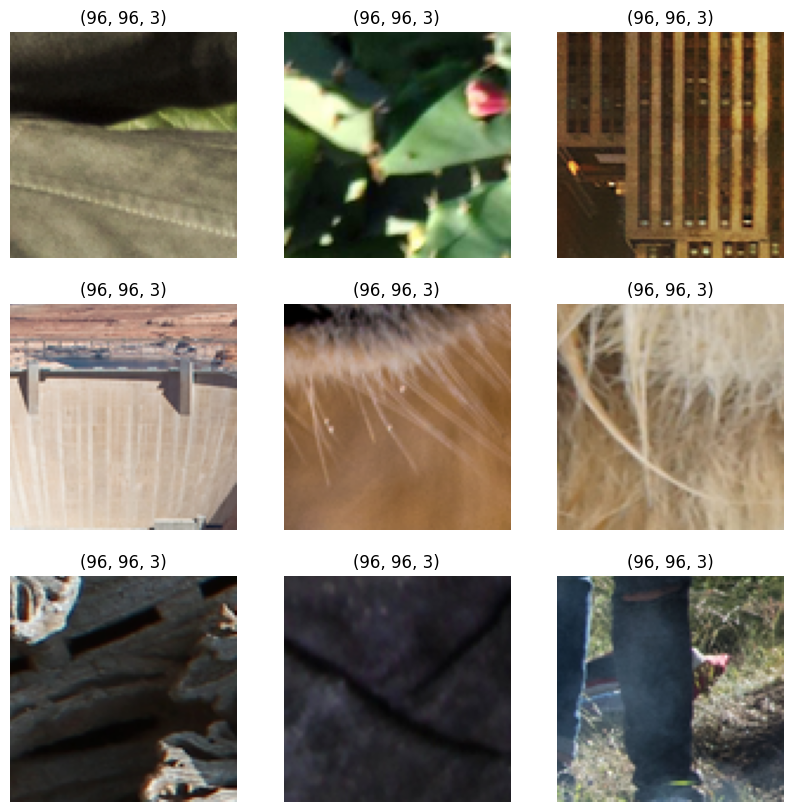

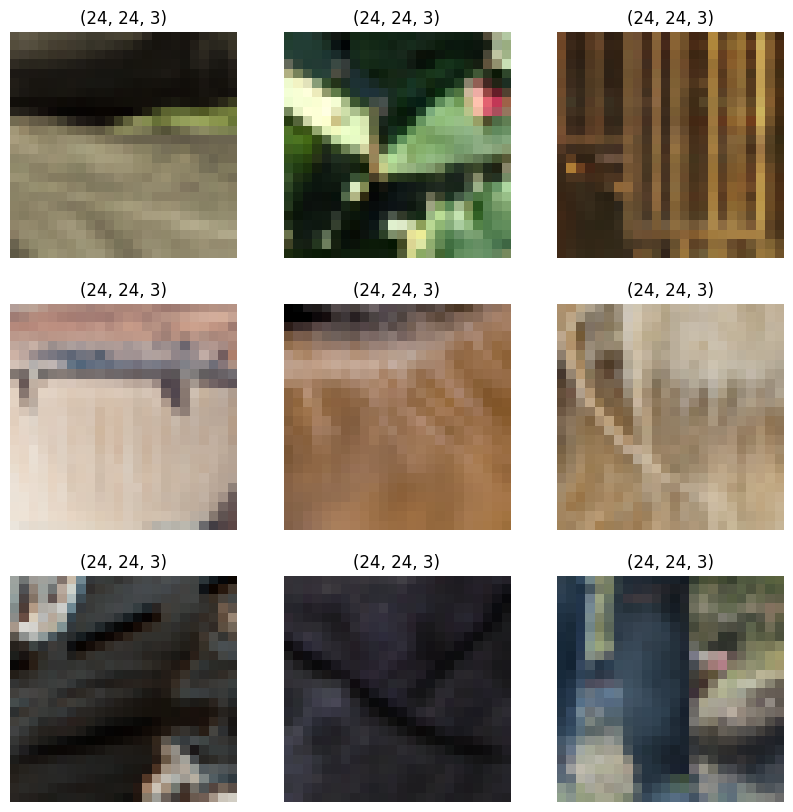

In [5]:
#Extraia um lote de imagens LR e seu lote HR correspondente do conjunto de treinamento train_ds
#iter() itera sobre o conjunto de dados
#next() é usado para obter o próximo elemento do iterador.
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
#itera sobre las 9 imgs
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # O valor máximo do pixel é 255 8bits
    # O primeiro elemento do tensor [0] é acessado, que será o valor psnr.
    # entre as imagens SR e a imagem original de alta resolução
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


## Build the model

In the paper, the authors train three models: EDSR, MDSR, and a baseline model. In this code example,
we only train the baseline model.

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

In [7]:

class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Descompacte os dados. Sua estrutura depende do seu modelo e
        # do que você passa para `fit()`.
        # x entrada de imagem, e saída esperada (etiqueta, imagem)
        x, y = data

        # Usado para registrar transações a termo para, em seguida, calcular gradientes
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Calcule o valor de perda das previsões y_pred e os rótulos verdadeiros y
            # (a função de perda é configurada em `compile()`)
            # Calcule a perda total do modelo, que inclui a perda de previsão, bem como as perdas de regularização.
            # Regularização técnica para evitar o ajuste excessivo, adicionando uma penalidade à perda total com base na complexidade do modelo
            #complexidade do modelo. self.losses contém as perdas de regularização.
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)


        # Calcula os gradientes da função de perda com relação aos pesos treináveis no modelo
        # Retorna a lista de todas as variáveis treináveis
        trainable_vars = self.trainable_variables
        #calcula os valores dos gradientes com relação às variáveis
        gradients = tape.gradient(loss, trainable_vars)
        # Atualizar pesos, o self optimizer é o otimizador configurado
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Atualizar métricas (inclui a métrica que rastreia a perda)
        self.compiled_metrics.update_state(y, y_pred)
        # Retorna um dicionário que mapeia os nomes de métricas para o valor atual
        # retorna um dicionário que mapeia os nomes das métricas para o valor atual
        #isso para monitorar o progresso do treinamento e obter métricas de desempenho
        return {m.name: m.result() for m in self.metrics}

#Modelo para predecir la imagen HR a partir de LR
    def predict_step(self, x):
        # Adicionando dimensão fictícia usando tf.expand_dims e convertendo para float32 usando tf.cast
        # Adicionando uma dimensão porque o modelo espera apenas uma imagem
        #Quando se espera que um modelo receba um lote de entradas de imagens como entrada, espera-se que ele seja
        #(batch_size, height, width, channels)
        #no entanto, o predict espera que uma única imagem de entrada seja recebida, não um lote, portanto, ele se expande com 1
        #1 indica que há apenas um elemento no eixo do lote=0
        # Img.LR é expandida por uma dimensão adicional (um eixo) usando tf.expand_dims
        # Uma nova dimensão está sendo adicionada ao início do tensor x xq axis=0
        # x é um tensor de altura, largura e canais da forma
        # Adicionar uma dimensão seria 1, altura, largura, canais e, em seguida, convertemos para .float.
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        #img.LR é passado para o modelo
        #training=False porque não está mais em treinamento
        # Passagem da imagem de baixa resolução para o modelo
        super_resolution_img = self(x, training=False)
        #tf.clip_by_value é usado para restringir os valores de pixel do img.SR de 0 a 255
        # Clica o tensor de min(0) a max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Arredonda os valores dos pixels para garantir que sejam inteiros cm
        # Arredonda os valores de um tensor para o número inteiro mais próximo
        super_resolution_img = tf.round(super_resolution_img)
        #removemos a dimensão de tamanho 1 e a convertemos em uint8
        # Remove as dimensões de tamanho 1 da forma de um tensor e as converte em uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
#imputs representa as características da entrada para o bloco residual.
def ResBlock(inputs):
    #Camada convolucional 64 filtros, tamanho 3x3
    #padding same, padding usado para que o tamanho da saída seja o mesmo que o tamanho da entrada
    #Função de ativação #relu
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    #aqui ocorre a operação residual, a entrada original é adicionada à saída
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    #camada de kernel 3x3 #filtros 64 multiplicados por 4
    #é feito para expandir os recursos espacialmente antes da upsampling
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    # A função depth_to_space() é usada para reorganizar os dados em x de acordo com o bloxk_size=upsampling.
    # Aumentando a resolução
    # conseguindo isso ao inserir novos valores entre os pixels existentes
    #resultando em uma imagem com um número maior de pixels e, portanto, uma resolução maior
    x = tf.nn.depth_to_space(x, block_size=factor)
    #Outra camada semelhante à primeira é aplicada para refinar ainda mais as características após o upsampling.
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    #Outro upsampling é feito para aumentar ainda mais a resolução das características.
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

#Crea el modelo
#num_filters, numero de filtros de las capas convolucionales
def make_model(num_filters, num_of_residual_blocks):
    # Entradas flexíveis para input_layer
    #shape=(None, None, 3) aceita imagens de qualquer tamanho com 3 canais
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    #O redimensionamento é aplicado para normalizar os valores entre 0 e 1 para facilitar o treinamento.
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    #conv é aplicado para processar os recursos de entrada x_new
    #é igual a x porque essa variável será usada posteriormente para adicionar às conexões residuais.
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    #se aplica otra capa conv a las caracteristicas
    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    # Uma conexão residual é feita adicionando-se as características de entrada
    #com os recursos após os blocos residuais, isso é feito elemento por elemento.
    x = layers.Add()([x, x_new])
    #aumentar a resolução
    x = Upsampling(x)
    #conv para produzir os caracteres de saída com três canais
    x = layers.Conv2D(3, 3, padding="same")(x)

    #rescaled para inverter a normalização para obter valores entre 0 e 255
    output_layer = layers.Rescaling(scale=255)(x)
    #O objeto EDSRModel é criado e retornado, que é o modelo completo.
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

## Train the model

In [8]:
# Usando o otimizador adam com taxa de aprendizado inicial de 1e-4, alterando a taxa de aprendizado após 5000 etapas para 5e-5
#boundaries=pasos de treinamento 5000 nos quais a taxa de aprendizado muda
#values = valor da taxa de aprendizado
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compilação do modelo com perda como erro absoluto médio (perda L1) e métrica como psnr
#Erro absoluto médio
#Matrica = PSNR relação sinal de pico/ruído
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Treinamento
# Com o conjunto de dados train_ds
# Especifica o número de épocas
# Especifica o número de etapas por época
# Especifica o conjunto de dados de validação
# O treinamento para mais épocas melhorará os resultados
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100
200/200 [==============================] - 92s 330ms/step - loss: 25.4178 - PSNR: 19.8906 - val_loss: 15.1315 - val_PSNR: 21.7635
Epoch 2/100
200/200 [==============================] - 7s 37ms/step - loss: 12.5936 - PSNR: 25.0813 - val_loss: 11.6668 - val_PSNR: 23.1991
Epoch 3/100
200/200 [==============================] - 7s 37ms/step - loss: 10.2108 - PSNR: 27.4129 - val_loss: 9.5895 - val_PSNR: 30.0242
Epoch 4/100
200/200 [==============================] - 7s 37ms/step - loss: 9.6382 - PSNR: 28.5400 - val_loss: 8.4431 - val_PSNR: 28.9253
Epoch 5/100
200/200 [==============================] - 7s 36ms/step - loss: 9.1278 - PSNR: 28.4471 - val_loss: 9.8441 - val_PSNR: 24.9319
Epoch 6/100
200/200 [==============================] - 8s 38ms/step - loss: 8.9014 - PSNR: 29.6622 - val_loss: 9.0670 - val_PSNR: 26.8969
Epoch 7/100
200/200 [==============================] - 7s 37ms/step - loss: 8.9061 - PSNR: 29.1516 - val_loss: 8.5591 - val_PSNR: 28.8939
Epoch 8/100
200/200 [======

## Run inference on new images and plot the results

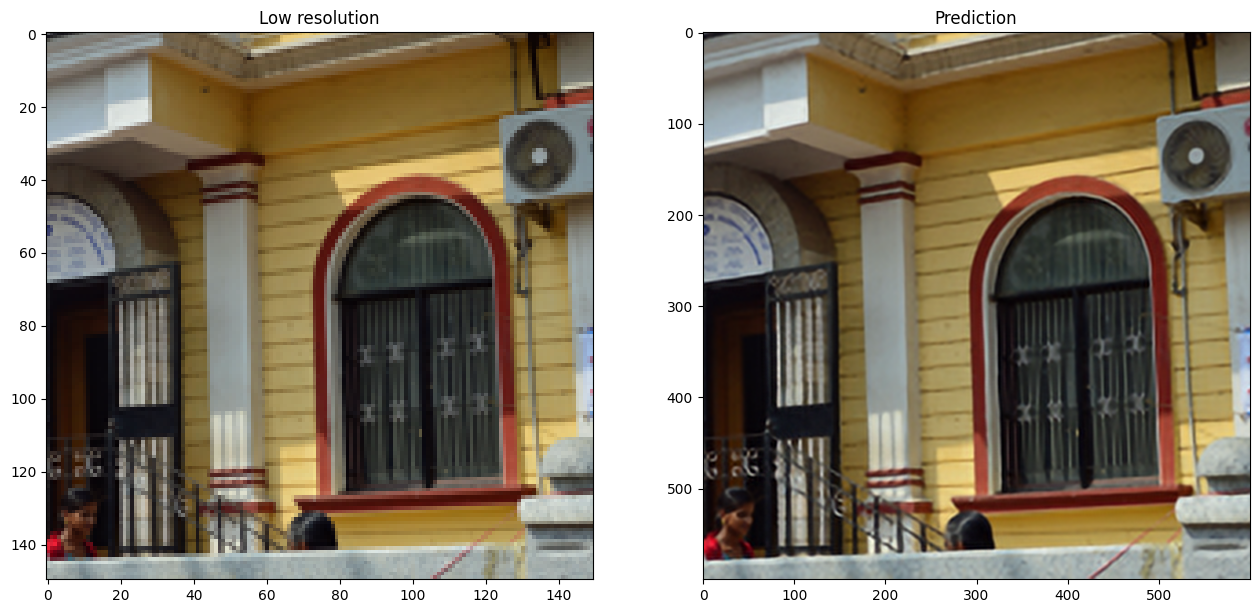

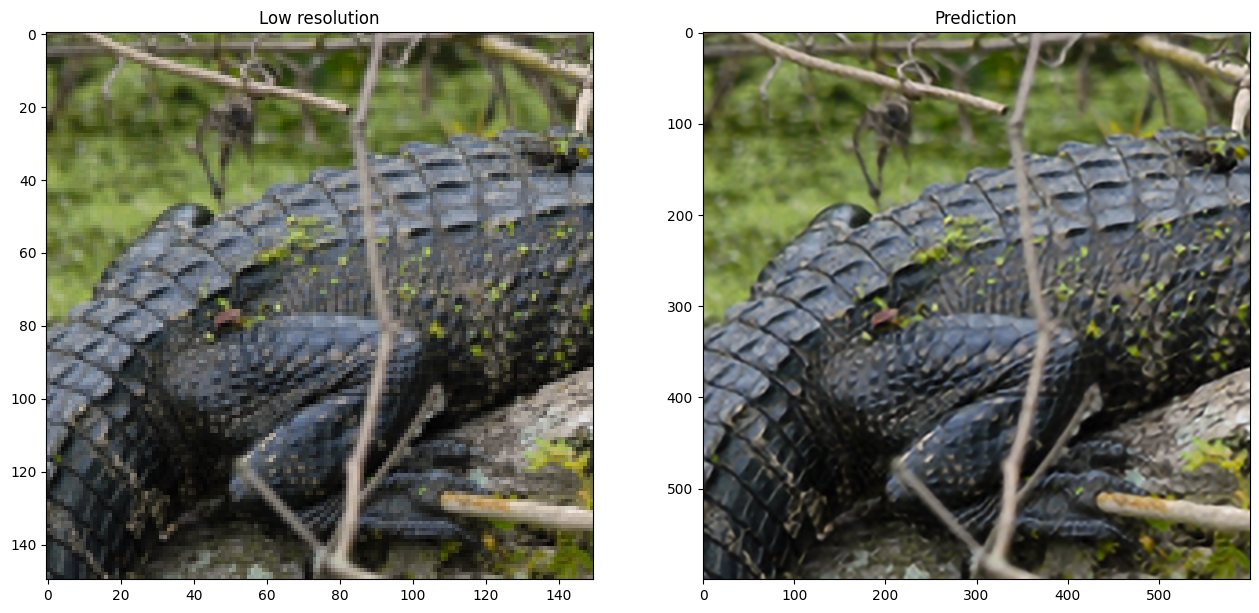

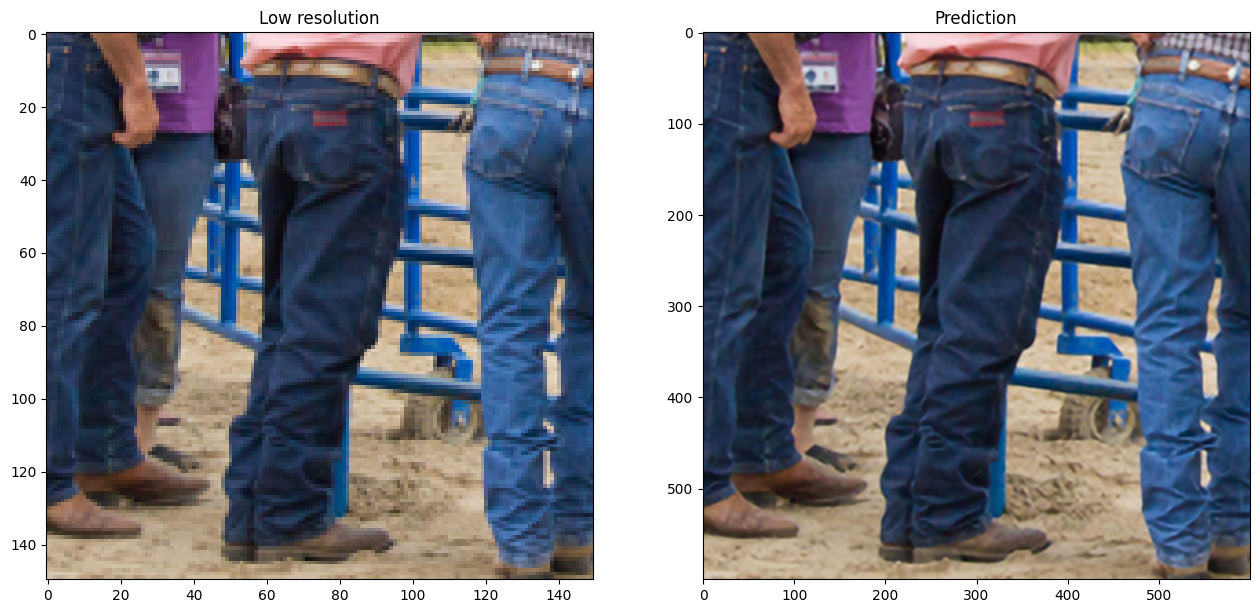

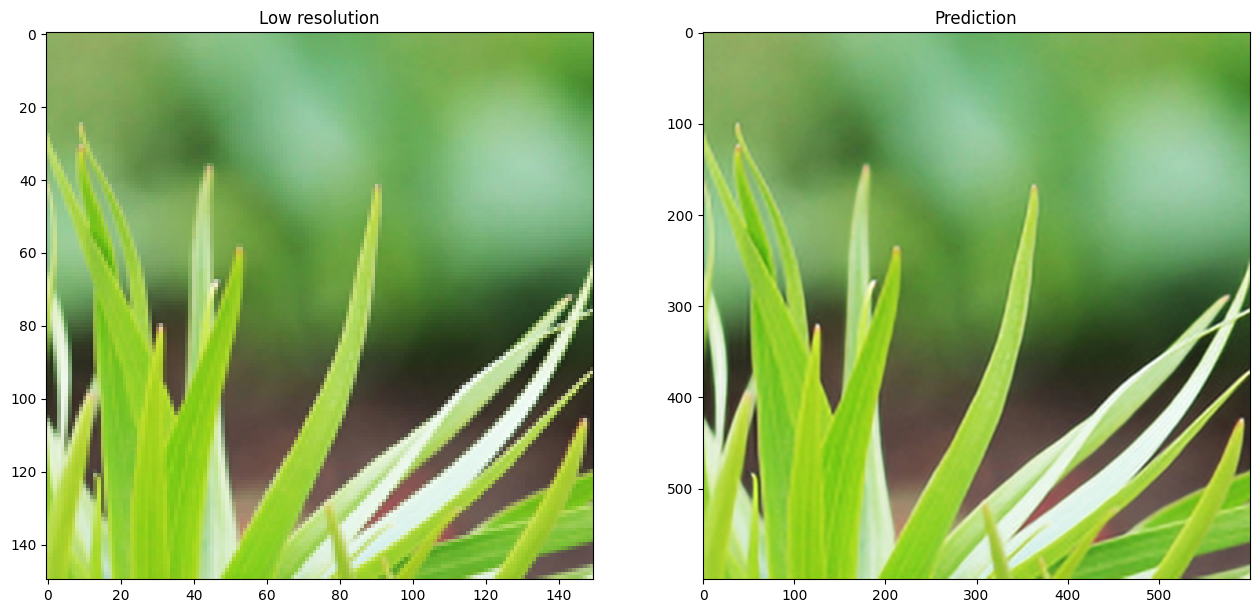

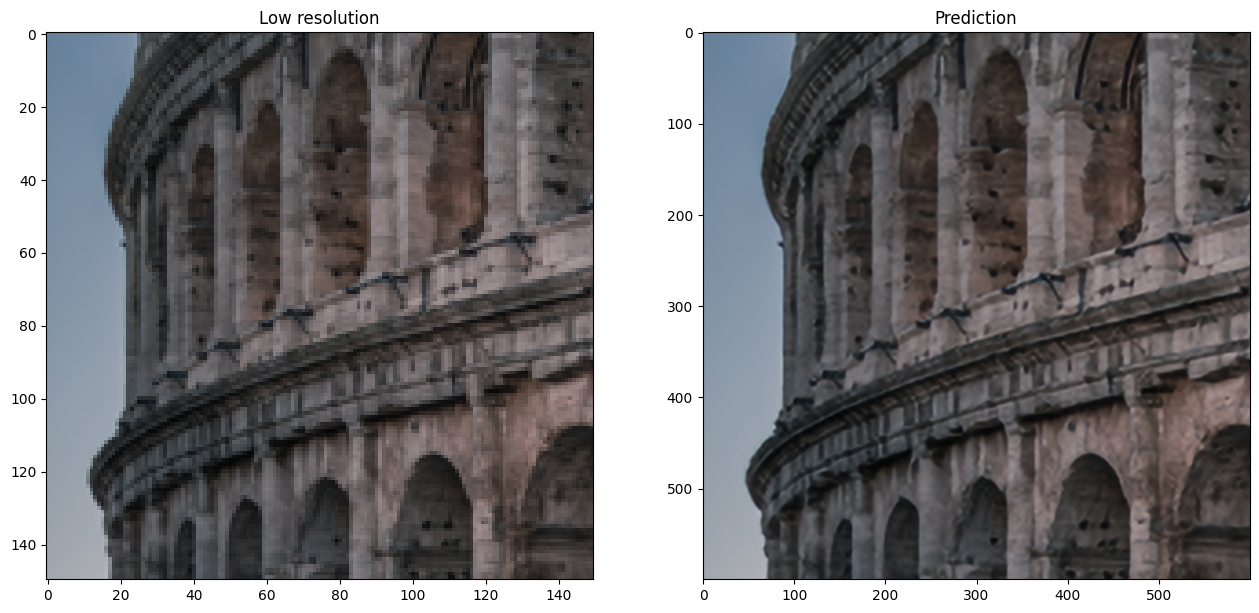

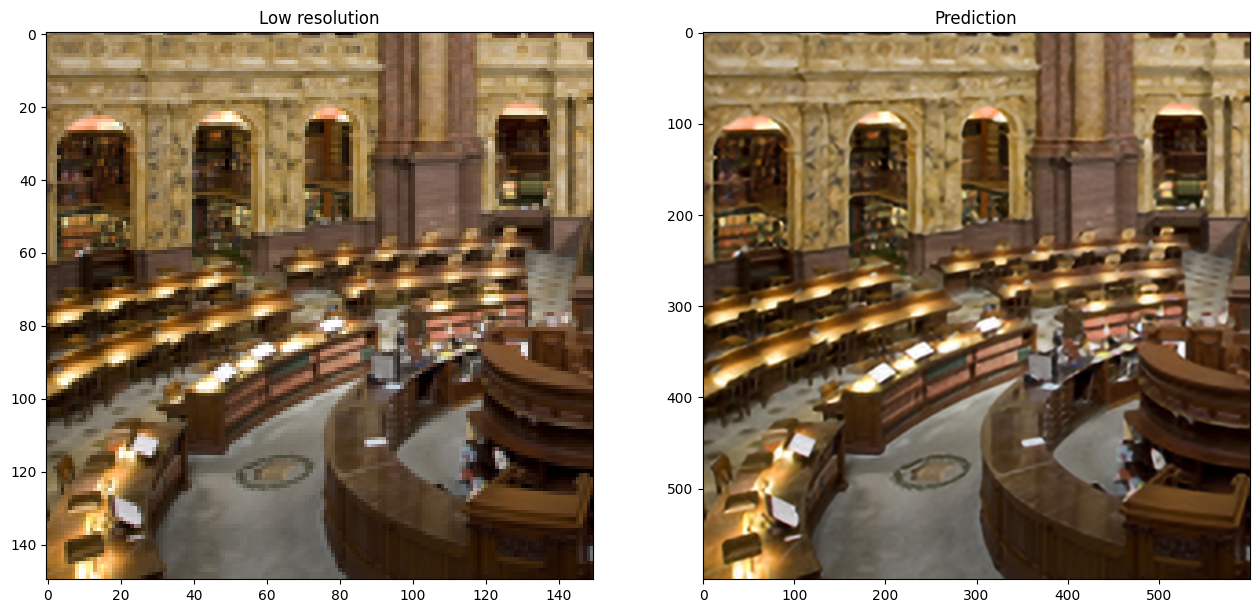

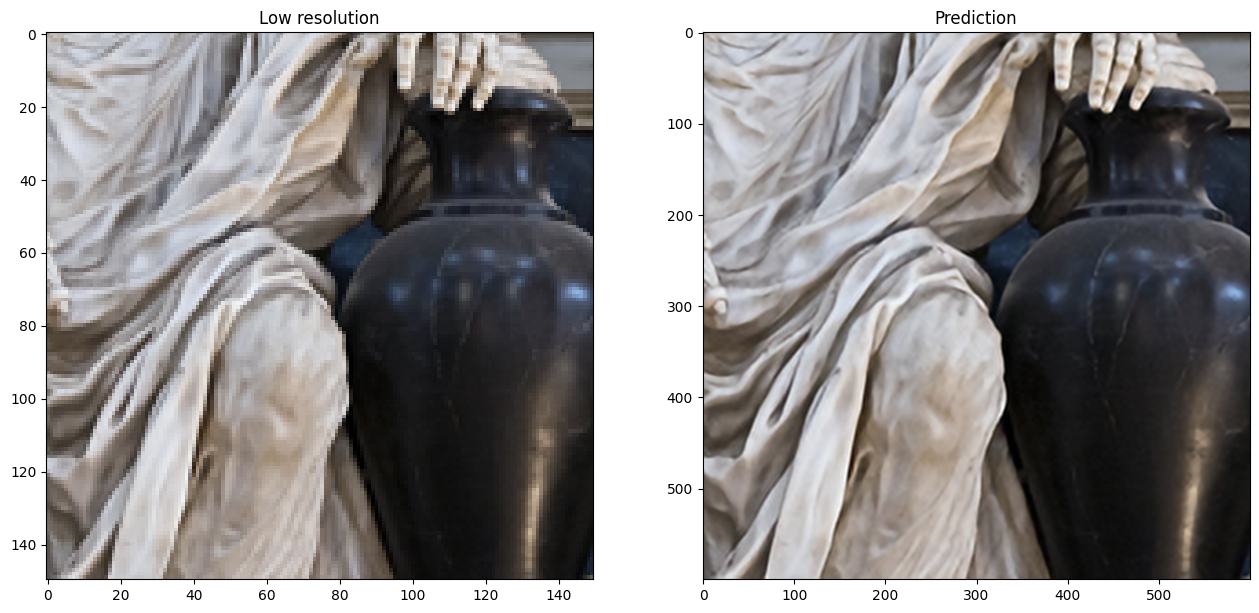

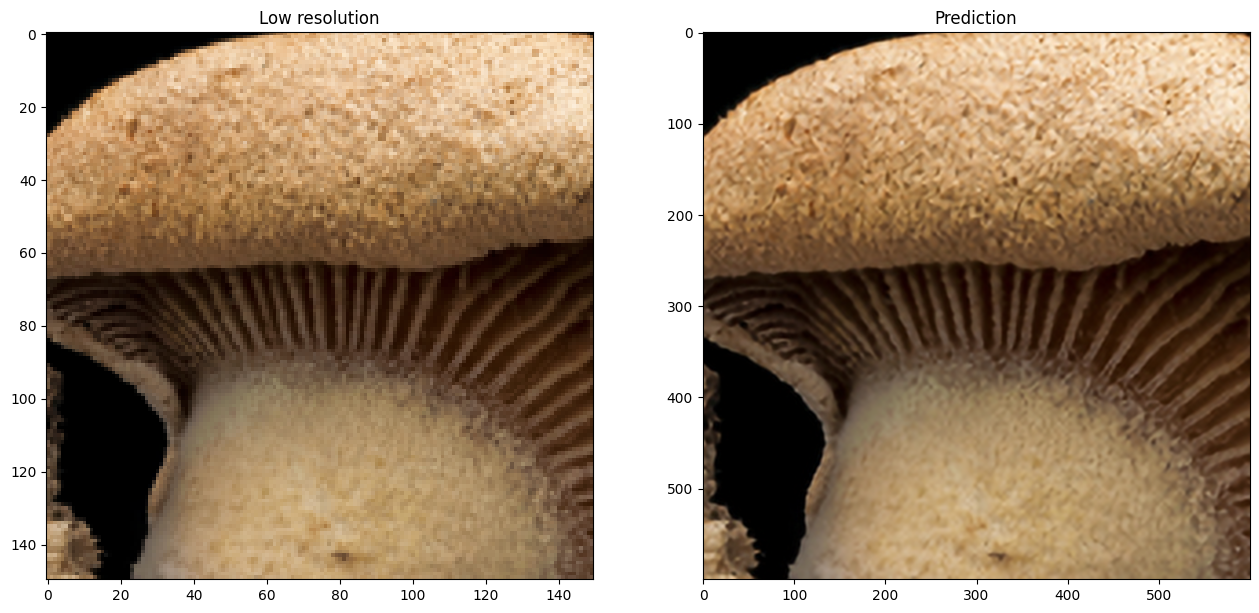

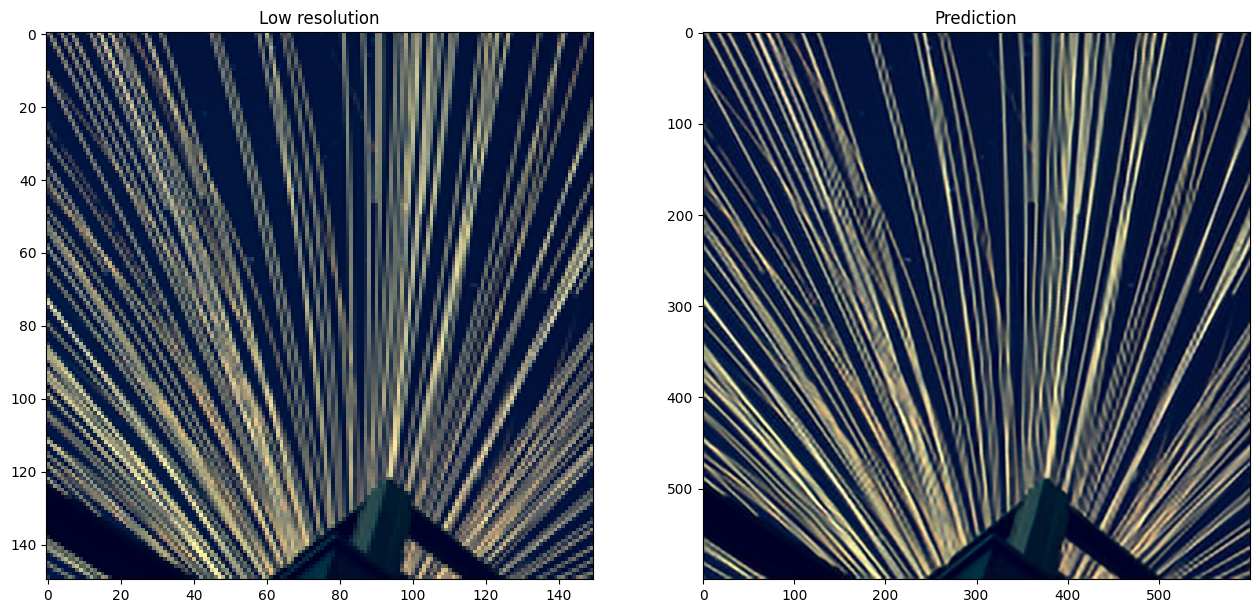

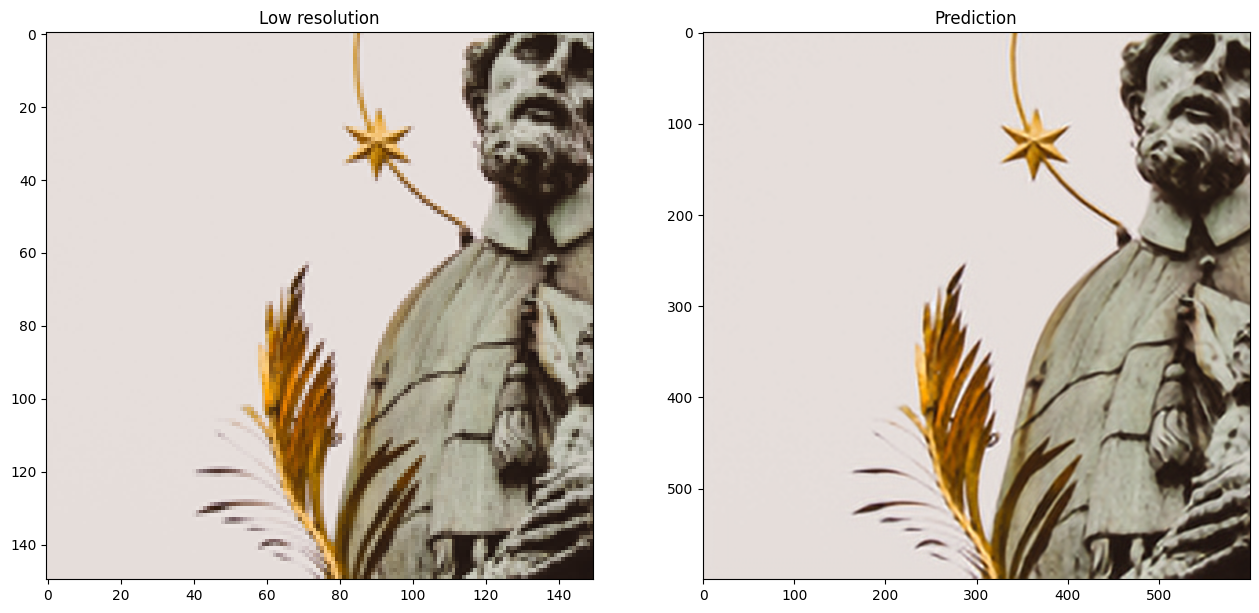

In [9]:

def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()

#itera sobre os 10 elementos do conjunto de dados de validação
for lowres, highres in val.take(10):
    #random_crop essa função é usada para um corte aleatório na imagem LR.
    #par get shape 150,150,3 isso é feito para ter um tamanho de entrada adequado para o modelo
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    #A previsão é feita chamando o modelo em que lowres é a imagem recortada.LR
    preds = model.predict_step(lowres)
    # visualizacion de las img LR y SR
    plot_results(lowres, preds)

## Final remarks

In this example, we implemented the EDSR model (Enhanced Deep Residual Networks for Single Image
Super-Resolution). You could improve the model accuracy by training the model for more epochs, as well as
training the model with a wider variety of inputs with mixed downgrading factors, so as to
be able to handle a greater range of real-world images.

You could also improve on the given baseline EDSR model by implementing EDSR+,
or MDSR( Multi-Scale super-resolution) and MDSR+,
which were proposed in the same paper.

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-EDSR-red.svg)](https://huggingface.co/keras-io/EDSR) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-EDSR-red.svg)](https://huggingface.co/spaces/keras-io/EDSR) |